https://www.kaggle.com/code/rinichristy/time-series-forecast-store-sales/notebook

PUNTAJE : 0.49976

## **Import the required libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from copy import copy
import warnings
warnings.filterwarnings('ignore')

## **Load the Store Sale dataset**

In [2]:
path='../Datasets/store-sales-time-series-forecasting/'
store_sales = pd.read_csv(path+'train.csv', usecols=['store_nbr', 'family', 'date', 'sales'],)
store_sales.head().style.set_properties(**{'background-color': 'LavenderBlush'})

,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.000000
1,2013-01-01,1,BABY CARE,0.000000
2,2013-01-01,1,BEAUTY,0.000000
3,2013-01-01,1,BEVERAGES,0.000000
4,2013-01-01,1,BOOKS,0.000000


In [3]:
store_sales_test = pd.read_csv(path+'test.csv', usecols=['store_nbr', 'family', 'date', 'id'])
store_sales_test.head().style.set_properties(**{'background-color': 'Lavender'})

,id,date,store_nbr,family
0,3000888,2017-08-16,1,AUTOMOTIVE
1,3000889,2017-08-16,1,BABY CARE
2,3000890,2017-08-16,1,BEAUTY
3,3000891,2017-08-16,1,BEVERAGES
4,3000892,2017-08-16,1,BOOKS


In [4]:
store_sales_test.tail().style.set_properties(**{'background-color': 'Lavender'})

,id,date,store_nbr,family
28507,3029395,2017-08-31,9,POULTRY
28508,3029396,2017-08-31,9,PREPARED FOODS
28509,3029397,2017-08-31,9,PRODUCE
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES
28511,3029399,2017-08-31,9,SEAFOOD


## **Data Exploration**

In [5]:
store_sales.info(), store_sales_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   date       object 
 1   store_nbr  int64  
 2   family     object 
 3   sales      float64
dtypes: float64(1), int64(1), object(2)
memory usage: 91.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         28512 non-null  int64 
 1   date       28512 non-null  object
 2   store_nbr  28512 non-null  int64 
 3   family     28512 non-null  object
dtypes: int64(2), object(2)
memory usage: 891.1+ KB


(None, None)

In [6]:
store_sales.isnull().sum(), store_sales_test.isnull().sum()

(date         0
 store_nbr    0
 family       0
 sales        0
 dtype: int64,
 id           0
 date         0
 store_nbr    0
 family       0
 dtype: int64)

In [8]:
pd.read_csv(path+"sample_submission.csv")

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


## **Data Preprocessing**

In [9]:
store_sales['date'] = pd.to_datetime(store_sales['date'])
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales_test['date'] = pd.to_datetime(store_sales_test['date'])
store_sales_test['date'] = store_sales_test.date.dt.to_period('D')

In [10]:
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales_test = store_sales_test.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales.head(), store_sales_test.head()

(                                 sales
 store_nbr family     date             
 1         AUTOMOTIVE 2013-01-01    0.0
                      2013-01-02    2.0
                      2013-01-03    3.0
                      2013-01-04    3.0
                      2013-01-05    5.0,
                                       id
 store_nbr family     date               
 1         AUTOMOTIVE 2017-08-16  3000888
                      2017-08-17  3002670
                      2017-08-18  3004452
                      2017-08-19  3006234
                      2017-08-20  3008016)

## **Determine seasonality**

**[Periodogram](https://online.stat.psu.edu/stat510/lesson/6/6.1)**

A periodogram is used to identify the dominant periods (or frequencies) of a time series. This can be a helpful tool for identifying the dominant cyclical behavior in a series, particularly when the cycles are not related to the commonly encountered monthly or quarterly seasonality.

Any time series can be expressed as a combination of cosine and sine waves with differing periods (how long it takes to complete a full cycle) and amplitudes (maximum/minimum value during the cycle). This fact can be utilized to examine the periodic (cyclical) behavior in a time series.

A time series is viewed as a sum of cosine waves with varying amplitudes and frequencies. One goal of an analysis is to identify the important frequencies (or periods) in the observed series. A starting tool for doing this is the periodogram. The periodogram graphs a measure of the relative importance of possible frequency values that might explain the oscillation pattern of the observed data.

A useful trigonometric identity is:
 $$A cos(2\pi\omega t + \phi) = \beta_1 cos(2\pi\omega t) + \beta_2 sin(2\pi\omega t) $$
 
 with $\beta_1 = A cos(\phi)$ and $\beta_2 = -A sin(\phi)$
 
 This identity is used when we determine the periodogram of a series.
 More information about Periodogram can be obtained from [here](https://online.stat.psu.edu/stat510/lesson/6/6.1).

In [11]:
Total_sales = store_sales.groupby('date').sum().squeeze().loc['2017']
Total_sales

date
2017-01-01    1.208250e+04
2017-01-02    1.402306e+06
2017-01-03    1.104377e+06
2017-01-04    9.900935e+05
2017-01-05    7.776210e+05
                  ...     
2017-08-11    8.263737e+05
2017-08-12    7.926305e+05
2017-08-13    8.656397e+05
2017-08-14    7.609224e+05
2017-08-15    7.626619e+05
Freq: D, Name: sales, Length: 227, dtype: float64

In [12]:
Total_sales_test = store_sales_test.drop('id', axis = 1).groupby('date').sum().squeeze().loc['2017']
Total_sales_test

""
date
2017-08-16
2017-08-17
2017-08-18
2017-08-19
2017-08-20
2017-08-21
2017-08-22
2017-08-23
2017-08-24


ModuleNotFoundError: No module named 'learntools'

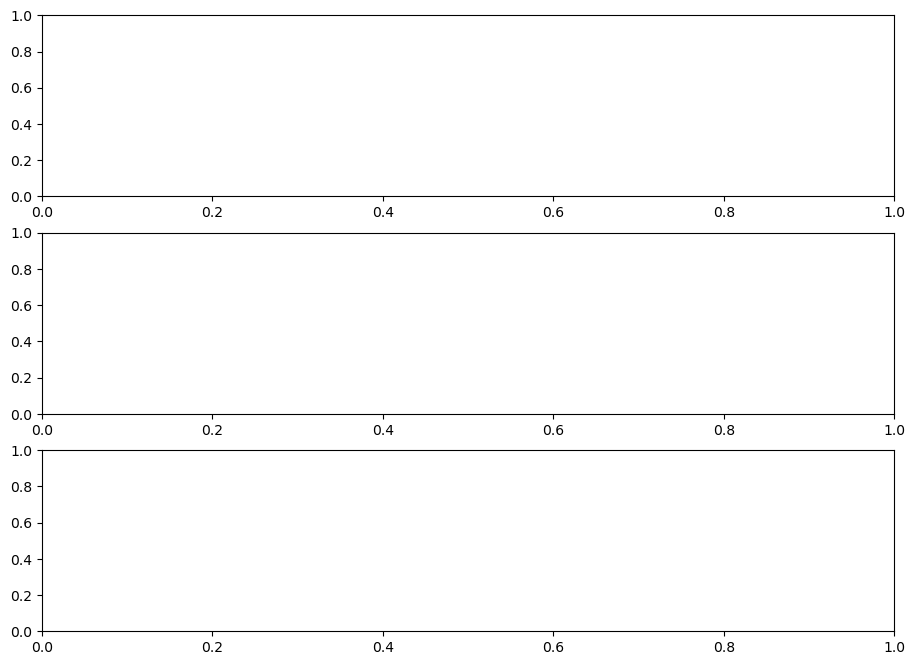

In [28]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(11, 8))

Total_sales = (store_sales.groupby('date').sum().squeeze())
from learntools.time_series.utils import plot_periodogram, seasonal_plot
plot_periodogram(Total_sales, ax=ax0);

X = Total_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
seasonal_plot(X, y='sales', period='week', freq='day', ax=ax1);
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax2);
plt.tight_layout();

**Periodogram and seasonal plot for the Year 2017**

ModuleNotFoundError: No module named 'learntools'

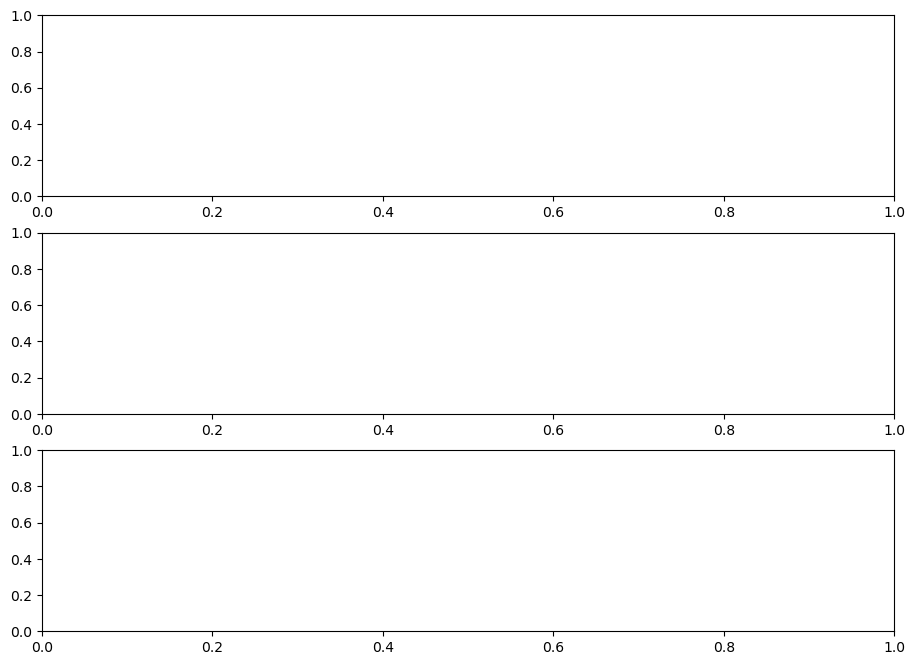

In [29]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(11, 8))

Total_sales = (store_sales.groupby('date').sum().squeeze().loc['2017'])
from learntools.time_series.utils import plot_periodogram, seasonal_plot
plot_periodogram(Total_sales, ax=ax0);

X = Total_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
seasonal_plot(X, y='sales', period='week', freq='day', ax=ax1);
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax2);
plt.tight_layout();

#### Both the seasonal plot and the periodogram suggest a strong weekly seasonality. From the periodogram, it appears there may be some monthly and biweekly components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.

## **Create seasonal features**
Use DeterministicProcess and CalendarFourier to create:

indicators for weekly seasons and
Fourier features of order 4 for monthly seasons.

In [ ]:
Total_sales

In [ ]:
y = Total_sales.copy()


from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
fourier = CalendarFourier(freq="M", order=4)  # 4 sin/cos pairs for "M"onthly seasonality

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # Monthly seasonality (fourier)
    drop=True,
)
X = dp.in_sample()  # create features for dates in average_sales.index

# Now fit the seasonal model.
# With our feature set created, we're ready to fit the model and make predictions. 
# We'll add a 16-day forecast to see how our model extrapolates beyond the training data. 
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
X_fore = dp.out_of_sample(steps=16)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
from learntools.time_series.style import *
ax = y.plot(**plot_params, alpha=0.5, title="Total Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
ax.legend();

## **Create Seasonal Model for the full Store Sales dataset**

Next, create a seasonal model of the same kind as above, but for the full Store Sales dataset with all 1800 time series.

In [ ]:
store_sales.unstack(['store_nbr', 'family'])

### **ARIMA**

In [ ]:
X = Total_sales.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
from statsmodels.tsa.arima.model import ARIMA
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

### **Deterministic with CalendarFourier**

In [ ]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
# Create training data
fourier = CalendarFourier(freq='M', order=4) # 4 sin/cos pairs for "M"onthly seasonality
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

### **Deterministic with Fourier**

In [ ]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.deterministic import Fourier

# Create training data
fourier = Fourier(period = 30, order=1)  
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

Next, create a feature set for the forecast period, and then creates the submission file `submission.csv`.

In [ ]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(store_sales_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)